In [1]:
from load_model_and_data import loader, known_skew
from bootstrapper import data_iterator, data_iterator_2d, get_init_time
import numpy as np
from os.path import join
import itertools
import pandas as pd
import collections
import seaborn as sns
import matplotlib.pyplot as plt
from metrics import stat_testing
import seaborn as sns
sns.set_theme()

In [2]:
lead_time = 'first_hour'
target = 'severe_hail'

(predictions, 
 X, y, 
     init_times, 
     test_dates,
    fti) = loader(lead_time, target)

/home/monte.flora/miniconda3/envs/wofs_test/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator SimpleImputer from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/monte.flora/miniconda3/envs/wofs_test/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/monte.flora/miniconda3/envs/wofs_test/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LogisticRegression from vers

In [3]:
init_time_rng = get_init_time(X, init_times)

In [4]:
inds = np.where(init_time_rng=='02:00 - 03:00')[0]
np.unique(init_times[inds])

array(['0200', '0230', '0300'], dtype=object)

In [5]:
# For the last initialization time, how dates had a tornado event? 
init_time_rng = get_init_time(X, init_times)
inds = np.where(init_time_rng=='02:00 - 03:00')[0]
np.unique(test_dates[inds])
for date in np.unique(test_dates[inds]):
    inds = np.where(test_dates==date)[0]
    count = np.sum(y[inds])
    if count > 0:
        print(date, count)

20170524 11.0
20170526 250.0
20180502 257.0
20180510 93.0
20180515 200.0
20180521 10.0
20180523 216.0
20180525 88.0
20180529 622.0
20180531 327.0
20180601 403.0
20180630 47.0
20190516 420.0
20190523 510.0
20190530 70.0
20200428 645.0
20200430 19.0
20200504 531.0
20200505 180.0
20200507 322.0
20200513 187.0
20200515 469.0
20200519 47.0
20200520 119.0
20200521 230.0
20200522 334.0
20200527 318.0
20200528 108.0
20210503 422.0
20210504 14.0
20210507 58.0
20210510 83.0
20210513 150.0
20210514 257.0
20210517 367.0
20210518 16.0
20210519 2.0
20210520 63.0
20210521 17.0
20210523 160.0
20210524 63.0
20210525 78.0
20210526 532.0
20210527 196.0


In [6]:
list(X.columns)

['srh_0to1_ens_mean_spatial_mean',
 'srh_0to3_ens_mean_spatial_mean',
 'cape_ml_ens_mean_spatial_mean',
 'cin_ml_ens_mean_spatial_mean',
 'shear_u_0to6_ens_mean_spatial_mean',
 'shear_v_0to6_ens_mean_spatial_mean',
 'shear_u_0to1_ens_mean_spatial_mean',
 'shear_v_0to1_ens_mean_spatial_mean',
 'lcl_ml_ens_mean_spatial_mean',
 'th_e_ml_ens_mean_spatial_mean',
 'u_10_ens_mean_spatial_mean',
 'v_10_ens_mean_spatial_mean',
 'mid_level_lapse_rate_ens_mean_spatial_mean',
 'low_level_lapse_rate_ens_mean_spatial_mean',
 'temperature_850mb_ens_mean_spatial_mean',
 'temperature_700mb_ens_mean_spatial_mean',
 'temperature_500mb_ens_mean_spatial_mean',
 'geopotential_height_850mb_ens_mean_spatial_mean',
 'geopotential_height_700mb_ens_mean_spatial_mean',
 'geopotential_height_500mb_ens_mean_spatial_mean',
 'dewpoint_850mb_ens_mean_spatial_mean',
 'dewpoint_700mb_ens_mean_spatial_mean',
 'dewpoint_500mb_ens_mean_spatial_mean',
 'uh_0to2_time_max_ens_mean_spatial_mean',
 'uh_2to5_time_max_ens_mean_sp

In [7]:
# Group Initialization times into overlapping hour periods (e.g., 2100-2200, 2200-2300, )
times_iterator = ['2000', '2030', '2100', '2130', '2200',
       '2230', '2300', '2330','0000', '0030', '0100', '0130', '0200', '0230', '0300',]
group = []
for i in range(len(times_iterator)-2):
    if i%2==0:
        group.append(list(times_iterator[i+d] for d in range(3)))
        
        
xdata_init_times=[]
for g in group:
    first_time = g[0][:2]+':'+g[0][2:]
    second_time = g[-1][:2]+':'+g[-1][2:]
    xdata_init_times.append(f'{first_time} - {second_time}')        

Text(0, 0.5, 'Average Updraft Speed\n(for examples with W > 20 m/s)')

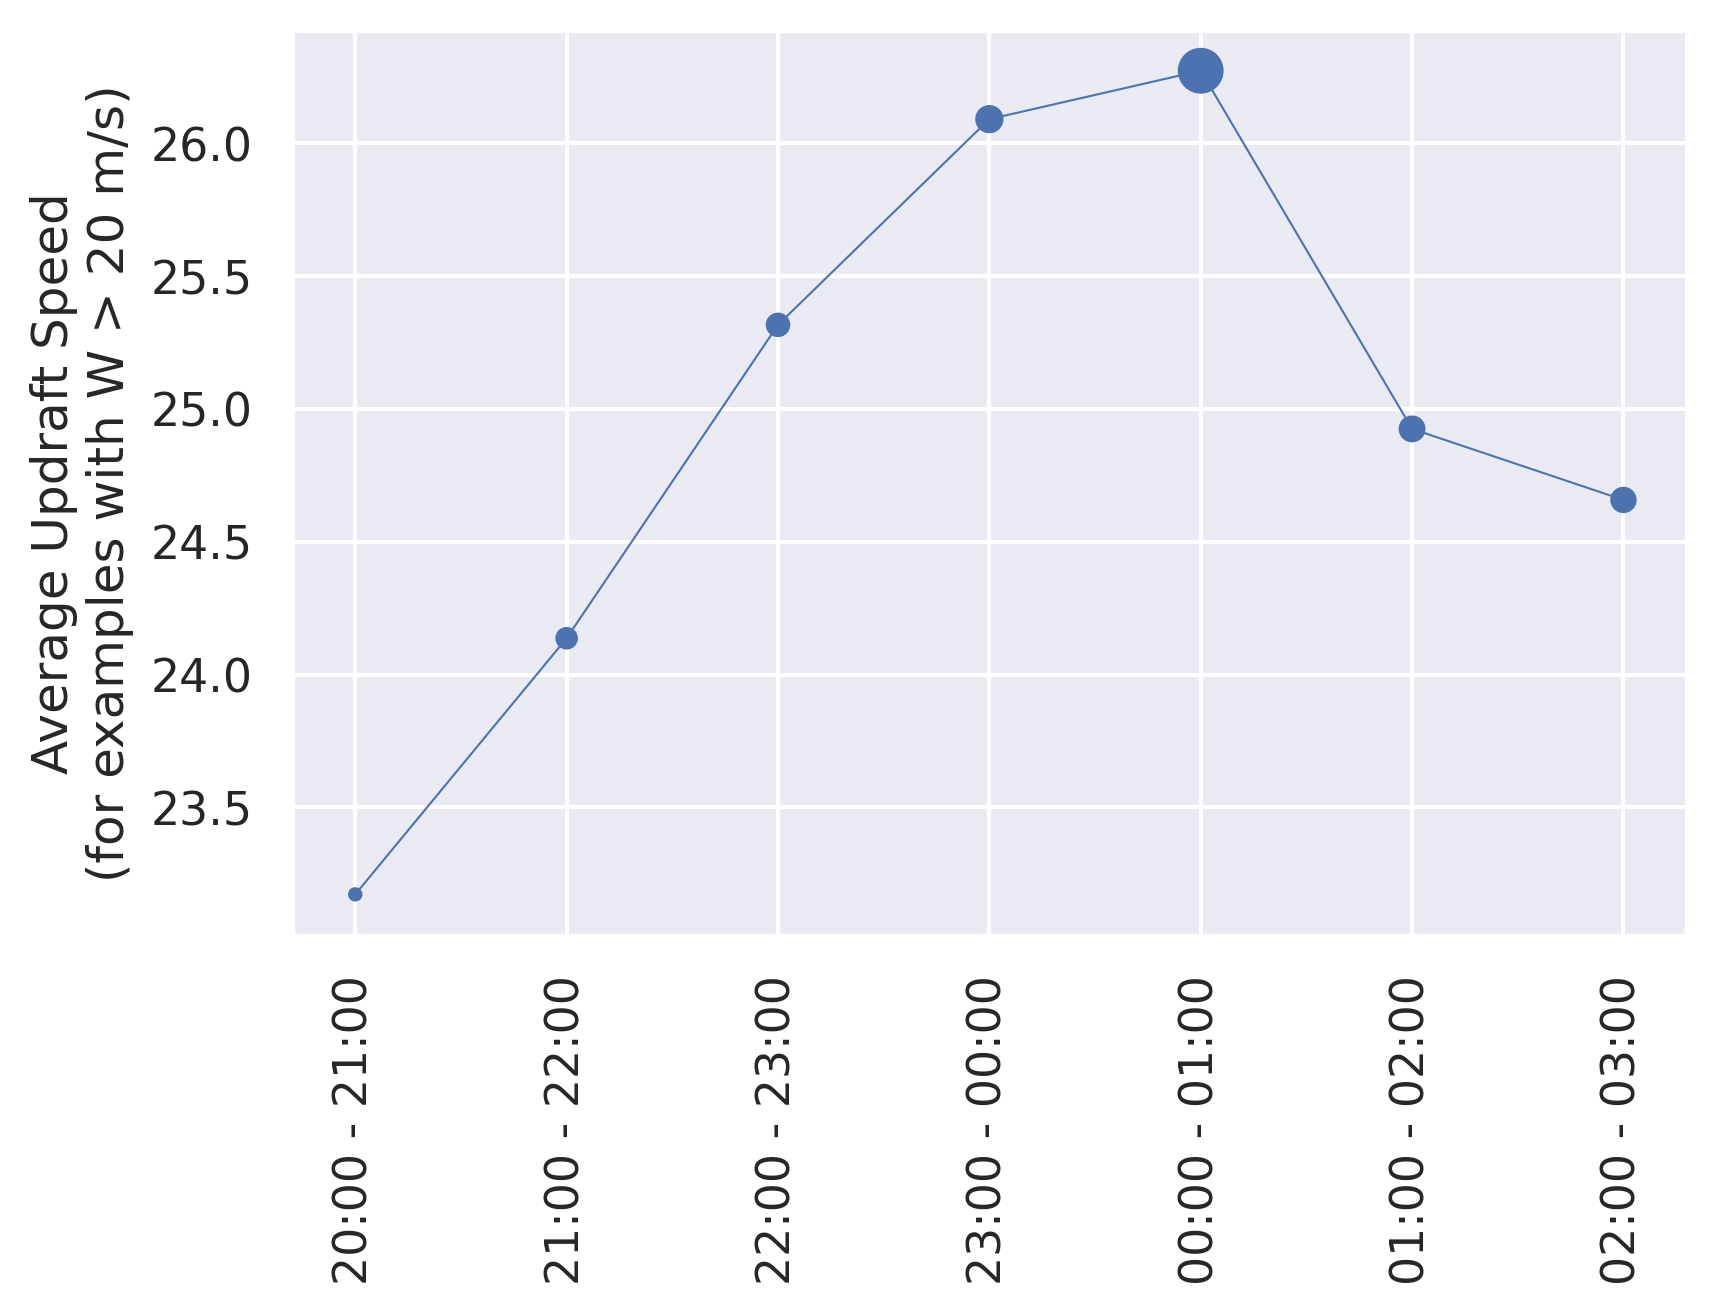

In [12]:
f, ax = plt.subplots(dpi=300,)

xx = X['w_up_time_max_ens_std_of_90th'].values
yy = X['w_up_time_max_ens_mean_of_90th'].values

means = []
stds = [] 
for i, item in enumerate(group):
    where_is_item = np.concatenate([np.where(init_times==sub)[0] for sub in item])
    x_sub = xx[where_is_item]
    y_sub = yy[where_is_item]
   
    inds = np.where(y_sub>20)[0]
    means.append(np.mean(y_sub[inds]))
    stds.append(np.mean(x_sub[inds]))

stds = np.array(stds)
ax.plot(np.arange(len(means)), means, lw=0.5)
ax.scatter(np.arange(len(means)), means, s=np.exp(stds)/10)
ax.set_xticks(np.arange(len(means)))
ax.set_xticklabels(xdata_init_times)
ax.tick_params(axis='x', labelrotation = 90)

ax.set_ylabel('Average Updraft Speed\n(for examples with W > 20 m/s)')

In [9]:
np.exp(stds)/10

array([ 6.05738732, 19.5773889 , 23.83219492, 33.35510835, 99.94929115,
       29.67403378, 28.32153205])

In [10]:
where_is_item1 = np.concatenate([np.where(init_times==sub)[0] for sub in group[0]])
new_scores = uh_sub = uh_vals[where_is_item1]

where_is_item2 = np.concatenate([np.where(init_times==sub)[0] for sub in group[1]])
old_scores = uh_sub = uh_vals[where_is_item2]

stat_testing(new_scores, old_scores)

NameError: name 'uh_vals' is not defined